In [1]:
# https://www.youtube.com/watch?v=Rxqp_sLSKAE

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [3]:
raw_df = pd.read_csv("./005930.KS.csv")
raw_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-04,6000.0,6110.0,5660.0,6110.0,4696.898438,74195000.0
1,2000-01-05,5800.0,6060.0,5520.0,5580.0,4289.475098,74680000.0
2,2000-01-06,5750.0,5780.0,5580.0,5620.0,4320.223633,54390000.0
3,2000-01-07,5560.0,5670.0,5360.0,5540.0,4258.725586,40305000.0
4,2000-01-10,5600.0,5770.0,5580.0,5770.0,4435.533691,46880000.0


In [4]:
raw_df['3MA']    = raw_df['Close'].pct_change(3)
raw_df['5MA']    = raw_df['Close'].pct_change(5)
raw_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,3MA,5MA
0,2000-01-04,6000.0,6110.0,5660.0,6110.0,4696.898438,74195000.0,NaN,NaN
1,2000-01-05,5800.0,6060.0,5520.0,5580.0,4289.475098,74680000.0,NaN,NaN
2,2000-01-06,5750.0,5780.0,5580.0,5620.0,4320.223633,54390000.0,NaN,NaN
3,2000-01-07,5560.0,5670.0,5360.0,5540.0,4258.725586,40305000.0,-0.09329,NaN
4,2000-01-10,5600.0,5770.0,5580.0,5770.0,4435.533691,46880000.0,0.03405,NaN


In [5]:
raw_df.shape

(5500, 9)

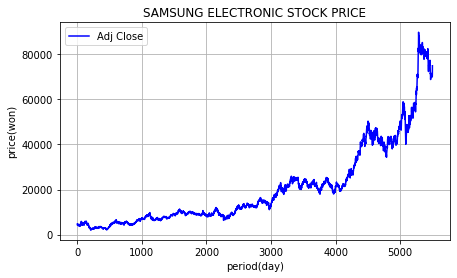

In [6]:
plt.figure(figsize=(7,4))

plt.title("SAMSUNG ELECTRONIC STOCK PRICE")
plt.ylabel("price(won)")
plt.xlabel("period(day)")
plt.grid()
plt.plot(raw_df['Adj Close'], label='Adj Close', color='b')
plt.legend(loc='best')

plt.show() #LSTM 이용하여 20년간의 주가데이터 학습

In [7]:
raw_df.isna().sum()

Date         0
Open         6
High         6
Low          6
Close        6
Adj Close    6
Volume       6
3MA          3
5MA          5
dtype: int64

In [8]:
raw_df.loc[raw_df["Open"].isna()]

,Date,Open,High,Low,Close,Adj Close,Volume,3MA,5MA
1304,2005-01-03,NaN,NaN,NaN,NaN,NaN,NaN,0.013498,0.029714
4513,2017-11-16,NaN,NaN,NaN,NaN,NaN,NaN,-0.018446,-0.017749
4518,2017-11-23,NaN,NaN,NaN,NaN,NaN,NaN,0.013768,0.011203
4542,2018-01-02,NaN,NaN,NaN,NaN,NaN,NaN,0.057261,0.037037
4755,2018-11-15,NaN,NaN,NaN,NaN,NaN,NaN,-0.024336,0.001135
5000,2019-11-14,NaN,NaN,NaN,NaN,NaN,NaN,0.017442,-0.007561


In [9]:
#Volume값0을 NAN으로 모두 대체(replace)
raw_df['Volume'] = raw_df["Volume"].replace(0, np.nan)
#0을 nan처리하여 outlier도 missing value로 인식하도록 처리

#각 columns에 0개수 확인
for col in raw_df.columns:
    missing_rows = raw_df.loc[raw_df[col]==0].shape[0]
    print(col + ': ' + str(missing_rows))

Date: 0
Open: 0
High: 0
Low: 0
Close: 0
Adj Close: 0
Volume: 0
3MA: 90
5MA: 57


In [10]:
raw_df = raw_df.dropna()
raw_df.isna().sum()
#dropna로 missingvalue도 삭제
# 데이터에는 아웃라이어나 미싱밸류 모두 정리

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
3MA          0
5MA          0
dtype: int64

In [11]:
# 날짜를 나타내는 Date항목을 제외한 숫자로 표현되는 모든 column에 대해 0~1값으로 정규화 수행

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

#정규화대상 column 정의
scale_cols = ['Open','High','Low','Close','Adj Close','Volume','3MA','5MA']

#정규화 수행
scaled_df = scaler.fit_transform(raw_df[scale_cols])

print(type(scaled_df), '\n') #리턴값은 넘파이

#정규화된 새로운 DataFrame 생성
scaled_df = pd.DataFrame(scaled_df, columns = scale_cols)
print(scaled_df)


<class 'numpy.ndarray'> 

          Open      High       Low     Close  Adj Close    Volume       3MA  \
0     0.037375  0.035517  0.038470  0.034440   0.026655  0.363715  0.550438   
1     0.034982  0.031689  0.036518  0.033873   0.026217  0.177799  0.563102   
2     0.034868  0.031689  0.036059  0.033760   0.026129  0.250704  0.469465   
3     0.036235  0.033177  0.037437  0.035120   0.027181  0.300555  0.514870   
4     0.039426  0.036368  0.040193  0.038178   0.029549  0.386615  0.637206   
...        ...       ...       ...       ...        ...       ...       ...   
5368  0.785779  0.736282  0.790997  0.776821   0.789315  0.066336  0.535894   
5369  0.783500  0.732029  0.782958  0.770024   0.782471  0.066996  0.495260   
5370  0.776664  0.725649  0.778365  0.764359   0.776768  0.061621  0.455475   
5371  0.773245  0.729902  0.777216  0.775688   0.788174  0.072643  0.489106   
5372  0.806290  0.768184  0.810519  0.817605   0.830377  0.117335  0.621863   

           5MA  
0     0.

In [13]:
# raw_df.head()
scaled_df.head()

,Open,High,Low,Close,Adj Close,Volume,3MA,5MA
0,0.037375,0.035517,0.038470,0.034440,0.026655,0.363715,0.550438,0.348063
1,0.034982,0.031689,0.036518,0.033873,0.026217,0.177799,0.563102,0.491642
2,0.034868,0.031689,0.036059,0.033760,0.026129,0.250704,0.469465,0.475502
3,0.036235,0.033177,0.037437,0.035120,0.027181,0.300555,0.514870,0.540115
4,0.039426,0.036368,0.040193,0.038178,0.029549,0.386615,0.637206,0.548732


In [14]:
#딥러닝 학습을 위한 입력데이터 feature column, 
#정답데이터 label column 정의 후 numpy로 변환하여 데이터 전처리 과정을 완료함

In [15]:
feature_cols=['3MA','5MA','Adj Close'] #feature 정의(입력데이터)
label_cols=['Adj Close'] #label 정의(정답데이터)

label_df = pd.DataFrame(scaled_df, columns = label_cols)
feature_df = pd.DataFrame(scaled_df, columns = feature_cols)

print(feature_df)
print(label_df)

#딥러닝 학습을 위해 DataFrame -> numpy로 변환
label_np = label_df.to_numpy()
feature_np = feature_df.to_numpy()

           3MA       5MA  Adj Close
0     0.550438  0.348063   0.026655
1     0.563102  0.491642   0.026217
2     0.469465  0.475502   0.026129
3     0.514870  0.540115   0.027181
4     0.637206  0.548732   0.029549
...        ...       ...        ...
5368  0.535894  0.467203   0.789315
5369  0.495260  0.459689   0.782471
5370  0.455475  0.454655   0.776768
5371  0.489106  0.462137   0.788174
5372  0.621863  0.534198   0.830377

[5373 rows x 3 columns]
      Adj Close
0      0.026655
1      0.026217
2      0.026129
3      0.027181
4      0.029549
...         ...
5368   0.789315
5369   0.782471
5370   0.776768
5371   0.788174
5372   0.830377

[5373 rows x 1 columns]


## 데이터 생성 - 입력데이터 feature / 정답 데이터 label

* (1) 학습 데이터 X, Y 생성

In [16]:
#입력 파라미터 feature, label -> numpy type

def make_sequence_dataset(feature, label, window_size):
    
    feature_list = [] #생성될 feature list
    label_list = [] #생성될 label list
    
    for i in range(len(feature)-window_size):
        
        feature_list.append(feature[i:i+window_size])
        #feature[i:i+window_size] 슬라이싱 이용하여 
        #[[..],[..]...]형상으로 입력데이터, 
        #즉 feature를 생성함
        #2차원 행렬 형태
        label_list.append(label[i+window_size])
        
    return np.array(feature_list), np.array(label_list)
# feature_list = [[..],[..]...]이므로 
# 리턴 값 np.array(feature_list)는 
# (batch_size, time_steps, input_dims)형상 가짐

#3차원 텐서 형태로 만들기

In [17]:
window_size = 40
X, Y = make_sequence_dataset(feature_np, label_np, window_size)
# 넘파이로 주어지는 시계열 데이터 
# feature_np, label_np로부터 
# window_size에 맞게 RNN입력데이터 X, 정답 데이터Y 생성함.
# 이때 리턴되는 입력데이터 X.shape = (batch_size, time_step, input_dims)

print(X.shape, Y.shape)

(5333, 40, 3) (5333, 1)


In [18]:
split = -200
#최근 주식 데이터 200개를 test로 분리

X_train = X[0:split]
y_train = Y[0:split]

X_test = X[split:]
y_test = Y[split:]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(5133, 40, 3) (5133, 1)
(200, 40, 3) (200, 1)


In [20]:
from keras.layers import GRU

model = Sequential()

model.add(GRU(256, #256개의 노드를 가지는 GRU 레이어와
              activation = 'tanh',#GRU계층에 tahn활성화 함수를 가지는 노드 수 256개
              input_shape = X_train[0].shape)) #input_shape = (40,3)

model.add(Dense(1, activation='linear'))#1개의 노드를 가지는 출력층으로 구성된 모델이 구축됨

# 은닉층 개념인 GRU레이어에서 tanh를 활성화함수로 가지는 노드수가 256개 이며
# 입력데이터는 40개의 데이터를 이용해서 미래값을 예측하는 문제이기 때문에
# input_shape은 (40,3)형태로 넣어준다
# 모델구축 완성


model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 256)               200448    
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 200,705
Trainable params: 200,705
Non-trainable params: 0
_________________________________________________________________


In [22]:
from tensorflow.keras.callbacks import EarlyStopping
model.compile(loss = 'mse', optimizer = 'adam', metrics = ['mae'])
# 손실함수 loss는 mse , 옵티마이저는 adam, metrics는 오차 절대값을 나타내는 mae로 설정하고
# 조기종료를 위해서 earlystopping 조건 설정 후 총 100번 반복해서 학습을 진행하면 손실함수값이 지속적으로 작아지다가 
# 10번째 지점에서 더이상 손실함수값이 작아지지 않기에 설정해놓은 earlystopping에 의해 조기종료됨을 알 수 있음


early_stop = EarlyStopping(monitor = 'val_loss', patience = 5)
model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=100, batch_size=16, callbacks=[early_stop])

Epoch 1/100
321/321 [==============================] - 8s 22ms/step - loss: 7.4003e-05 - mae: 0.0055 - val_loss: 2.9542e-04 - val_mae: 0.0147
Epoch 2/100
321/321 [==============================] - 7s 21ms/step - loss: 4.7633e-05 - mae: 0.0048 - val_loss: 1.2767e-04 - val_mae: 0.0086
Epoch 3/100
321/321 [==============================] - 7s 21ms/step - loss: 5.0998e-05 - mae: 0.0051 - val_loss: 2.7636e-04 - val_mae: 0.0137
Epoch 4/100
321/321 [==============================] - 7s 21ms/step - loss: 4.4581e-05 - mae: 0.0047 - val_loss: 1.4270e-04 - val_mae: 0.0089
Epoch 5/100
321/321 [==============================] - 7s 22ms/step - loss: 4.9985e-05 - mae: 0.0051 - val_loss: 1.3929e-04 - val_mae: 0.0092
Epoch 6/100
321/321 [==============================] - 7s 21ms/step - loss: 3.9486e-05 - mae: 0.0043 - val_loss: 1.1951e-04 - val_mae: 0.0082
Epoch 7/100
321/321 [==============================] - 7s 21ms/step - loss: 3.9654e-05 - mae: 0.0044 - val_loss: 3.5390e-04 - val_mae: 0.0166
Epoch 

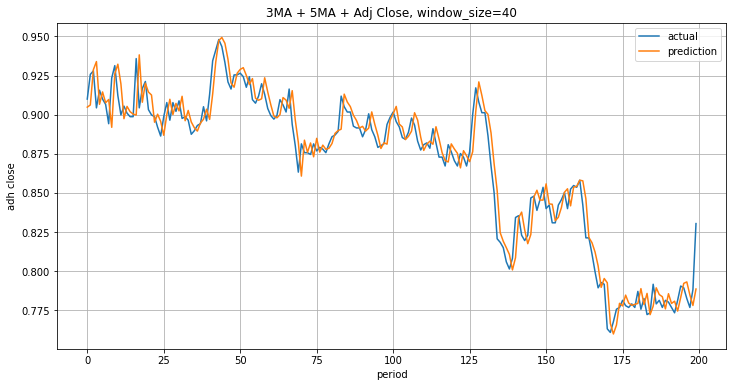

In [30]:
pred = model.predict(X_test)
#200개의 test데이터를 이용해서 예측

plt.figure(figsize=(12,6))
plt.title('3MA + 5MA + Adj Close, window_size=40')
plt.ylabel('adh close')
plt.xlabel('period')
plt.plot(y_test, label='actual')
plt.plot(pred, label='prediction')
plt.grid()
plt.legend(loc='best')

plt.show()

